# Introduction

------------------------------
## Mission - Réalisez une classification supervisée d'images
------------------------------

Vous continuez votre travail au sein de "Place du marché". Vous avez partagé le travail effectué lors de votre mission précédente avec Lead Data Scientist, Linda. Elle vous invite désormais à aller plus loin dans l’analyse d’images. 

Voici le mail qu’elle vous a envoyé.

*Bonjour,*

*Merci beaucoup pour ton travail ! Voici la suite de ta mission :*

*Pourrais-tu réaliser une **classification supervisée à partir des images** ? Je souhaiterais que tu mettes en place une **data augmentation** afin d’optimiser le modèle.*

*De plus, nous souhaitons élargir notre gamme de produits à l’épicerie fine.*

*Pour cela, pourrais-tu tester la collecte de produits à base de “champagne” via l’[API disponible ici](https://developer.edamam.com/food-database-api) ou via l'API Openfood Facts en pièce jointe (ne nécessitant aucune inscription)?*

*Pourrais-tu ensuite nous proposer un **script** ou **notebook Python** permettant une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.*

*Enfin, pourrais-tu formaliser dans un **support de présentation** de 30 slides maximum au format PDF **l’ensemble de ta démarche** ainsi que les **résultats** d’analyse les plus pertinents ?*

*Merci encore, bon courage !*

*Linda*

*PS : En pièce jointe, tu trouveras pour t’aider un **exemple** de mise en œuvre de classification supervisée sur un autre dataset.*

# Import des librairies

In [1]:
## Global 
import os
import shutil
import time
import pandas as pd
import numpy as np

# sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, auc, \
                                roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from plot_keras_history import show_history, plot_history

# Pickle
from pickle import dump, load

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

2025-02-23 13:59:12.658736: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 13:59:12.667129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740315552.675964 2258835 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740315552.678714 2258835 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 13:59:12.689105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Initialize sns
sns.set()

# Lecture du dataset

In [3]:
# Read the dataset from the csv file 
df = pd.read_csv("./data/flipkart_com-ecommerce_sample_1050.csv")

In [4]:
# Define a list of columns to keep
selected_columns = ["product_category_tree", "image"]
# Filter the dataframe with the selected columns
df = df[selected_columns]
df.head()

,product_category_tree,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


## Remaniement du champ image

In [5]:
# Define path to images
path_to_images = "./data/images/"

In [6]:
# Concatenate the path to the name of the image
df["image"] = path_to_images + df["image"]
df.head()

,product_category_tree,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",./data/images/55b85ea15a1536d46b7190ad6fff8ce7...
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",./data/images/7b72c92c2f6c40268628ec5f14c6d590...
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",./data/images/64d5d4a258243731dc7bbb1eef49ad74...
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",./data/images/d4684dcdc759dd9cdf41504698d737d8...
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",./data/images/6325b6870c54cd47be6ebfbffa620ec7...


## Remaniement des catégories

In [7]:
# Suppress the [" and "] characters
df["product_category_tree"] = df["product_category_tree"].apply(lambda i : i.replace('["', ''))
df["product_category_tree"] = df["product_category_tree"].apply(lambda i : i.replace('"]', ''))
# Get the values of the product_category_tree in a series
product_category_tree = df["product_category_tree"]
# Split the product_category_tree and store it in a list
categories_list = product_category_tree.apply(lambda i : i.split(">>"))
# Go through categories_list and get the biggest list
max_size = 0
for i in range(len(categories_list)):
    # Check if the size is greater than the max_size already found
    if len(categories_list[i]) > max_size:
        # Set the max_size to the new max size
        max_size = len(categories_list[i])
# Generate the columns names based on the max_size
columns = list(range(1,max_size+1))
# Create a dataframe from the list of categories
categories_df = pd.DataFrame(categories_list.to_list(), columns=columns)
# Get the first column of categories_df and set it in a new column in df
df["category"] = categories_df.iloc[:,0]
df = df.drop("product_category_tree", axis=1)
df.head()

,image,category
0,./data/images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing
1,./data/images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care
2,./data/images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care
3,./data/images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing
4,./data/images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing


In [8]:
categories_list = df["category"].unique()

## Encodage de la catégorie

In [9]:
# Define a LabelEncoder
le = LabelEncoder()
# Train the LabelEconder with our categories
le.fit(df["category"])
# Generate the labels
df["label"] = le.transform(df["category"])

# Classification supervisée

## Création du modèle de classification

In [10]:
def create_model():
    # Implement the pretrained model
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    
    # Set layers to non trainable to keep the weights of the pretrained model
    for layer in model0.layers:
        layer.trainable = False

    # Get the output layer of the model
    output = model0.output
    # Upgrade the model
    output = GlobalAveragePooling2D()(output)
    output = Dense(256, activation="relu")(output)
    output = Dropout(0.5)(output)
    # Define the new output with 7 classes and a softmax function
    predictions = Dense(7, activation="softmax")(output)

    # Redefine the whole model
    model = Model(inputs=model0.input, outputs=predictions)
    # Compile the new model
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    print(model.summary())

    return model

## Première approche

Pour la première approche, nous ferons une préparation initiale simple de l'ensemble des images avant une classification supervisée.

### Création d'un jeu de données de validation

In [11]:
# Split data and labels
data = df["image"]
labels = to_categorical(df["label"])
# Split into work data and validation data
X, X_test, y, y_test = train_test_split(data, labels, test_size=0.15, random_state=8)

### Création d'un jeu de données d'entrainement et de test

In [12]:
# Split into train data and test data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.25, random_state=8)

### Préparation des images

In [13]:
def prepare_images(data):
    # Create a list to store prepared images
    prepared_images = []
    # For each image
    for image in data:
        # Load the image from file
        image = load_img(image, target_size=(224,224))
        # Convert it to a numpy array
        image = img_to_array(image)
        # Reshape the image to fit the model needs
        image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
        # Preprocess the image
        image = preprocess_input(image)
        # Convert the image to an array and store it in the list
        prepared_images.append(image)
        
    return np.array(prepared_images)

In [14]:
# Prepare our datasets train/test/validation
X_train = prepare_images(X_train)
X_val = prepare_images(X_val)
X_test = prepare_images(X_test)

/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### Définition du modèle

In [15]:
# Create the model
with tf.device("/gpu:0"):
    model1 = create_model()

# Create the path where to save the trained model
model1_save_path = "./model1_best_weights.keras"
# Create the path where to save the logs of the training
model1_log_path = "./model1_training_log"
# Create checkpoints to save the model
checkpoint = ModelCheckpoint(model1_save_path, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode="min",)
# Create EarlyStopping to stop the training if the model find convergence before the end of the training
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# Create the list of callbacks
callbacks_list = [checkpoint, early_stopping]

2025-02-23 13:59:20.087072: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-23 13:59:20.087087: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: lalende
2025-02-23 13:59:20.087090: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: lalende
2025-02-23 13:59:20.087199: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-02-23 13:59:20.087208: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-02-23 13:59:20.087210: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Entrainement du modèle

In [16]:
# Check if the model have already been trained (and saved)
# If true, load the model from the save made
# Used mainly to save time replaying the notebook
if os.path.exists(model1_save_path):
    # Open the model from the file
    model1 = load_model(model1_save_path)
    # Open the log file of training
    history1 = np.load(model1_log_path + ".npy", allow_pickle="True").item()
else:
    # Training of the model on the train set
    with tf.device("/gpu:0"):
        history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                             callbacks=callbacks_list, validation_data=(X_val, y_val),
                             verbose=1)
        # Save the history of training to a file
        np.save(model1_log_path, history1.history)

### Scoring et analyse

In [17]:
# Get the scores 
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9900 - loss: 0.0233
Training Accuracy: 0.9962

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8522 - loss: 0.7706
Validation Accuracy:  0.8365


In [18]:
# Get the scores of the optimal epoch
model1.load_weights(model1_save_path)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy       :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy :  {:.4f}".format(accuracy))

Validation Accuracy       :  0.8365
Test Accuracy :  0.8354


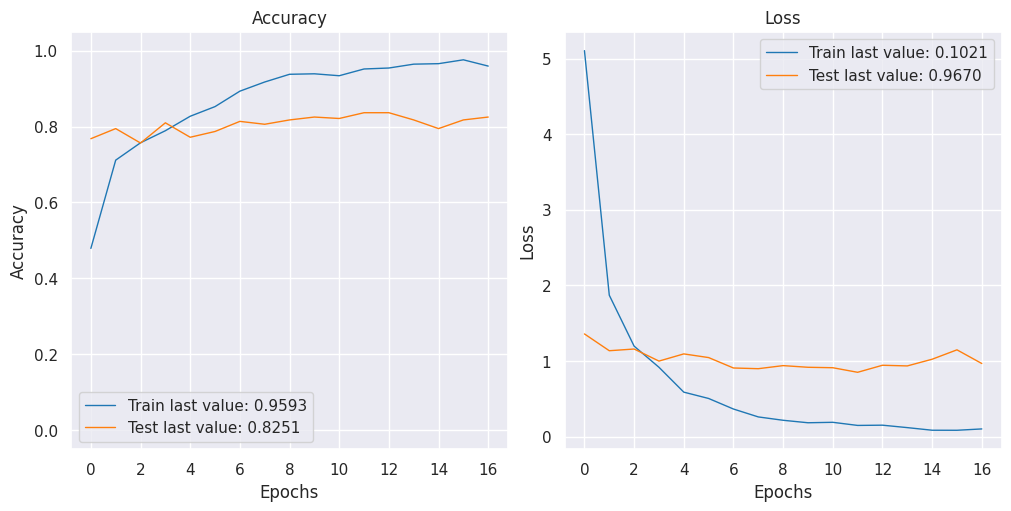

In [19]:
# Plot the history of training
show_history(history1)
plot_history(history1, path="model1_history.png")
plt.close()

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


<Axes: >

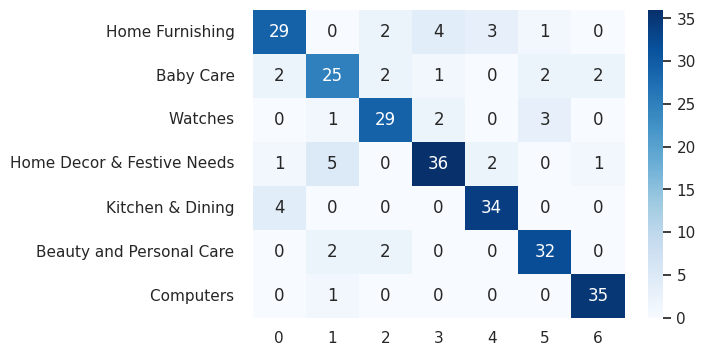

In [20]:
# Get the values of the clusters
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
# Calculate the confusion matrix 
conf_mat = confusion_matrix(y_val_true, y_val_pred)
# Convert the confusion matrix to a DataFrame
df_conf_mat = pd.DataFrame(conf_mat, index = [label for label in categories_list],
                  columns = [i for i in "0123456"])
# Plot it
plt.figure(figsize = (6,4))
sns.heatmap(df_conf_mat, annot=True, cmap="Blues")

## Seconde approche

Pour la seconde approche, nous ferons une data augmentation avec ImageDataGenerator pour le preprocessing de nos images. 

### Création d'un jeu de données de validation

In [21]:
# Split into work data and test data
data, data_test = train_test_split(df, test_size=0.15, random_state=8)

### Préparation des images

In [22]:
# Create the ImageDataGenerator for the train/validation set
image_data_generator_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

# Create the ImageDataGenerator for the test set
image_data_generator_validation = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

In [23]:
# Create the flow for the 3 datasets
train_flow = image_data_generator_train.flow_from_dataframe(
    data, directory="", x_col="image", y_col="category",
    weight_col=None, target_size=(224, 224), classes=None, class_mode="categorical",
    batch_size=32, shuffle=True, seed=8, subset="training",
)
validation_flow = image_data_generator_train.flow_from_dataframe(
    data, directory="", x_col="image", y_col="category",
    weight_col=None, target_size=(224, 224), classes=None, class_mode="categorical",
    batch_size=32, shuffle=True, seed=8, subset="validation",
)
test_flow = image_data_generator_validation.flow_from_dataframe(
    data_test, directory="", x_col="image", y_col="category",
    weight_col=None, target_size=(224, 224), classes=None, class_mode="categorical",
    batch_size=32, shuffle=True, seed=8, subset=None   
)

Found 669 validated image filenames belonging to 7 classes.
Found 223 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


### Définition du modèle

In [24]:
# Create the model
with tf.device("/gpu:0"):
    model2 = create_model()

# Create the path where to save the trained model
model2_save_path = "./model2_best_weights.keras"
# Create the path where to save the logs of the training
model2_log_path = "./model2_training_log"
# Create checkpoints to save the model
checkpoint = ModelCheckpoint(model2_save_path, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode="min",)
# Create EarlyStopping to stop the training if the model find convergence before the end of the training
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# Create the list of callbacks
callbacks_list = [checkpoint, early_stopping]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Entrainement du modèle

In [25]:
# Check if the model have already been trained (and saved)
# If true, load the model from the save made
# Used mainly to save time replaying the notebook
if os.path.exists(model2_save_path):
    # Open the model from the file
    model2 = load_model(model2_save_path)
    # Open the log file of training
    history2 = np.load(model2_log_path + ".npy", allow_pickle="True").item()
else:
    # Training of the model on the train set
    with tf.device("/gpu:0"):
        history2 = model2.fit(train_flow, epochs=50, batch_size=64,
                             callbacks=callbacks_list, validation_data=test_flow,
                             verbose=1)
        # Save the history of training to a file
        np.save(model2_log_path, history2.history)

### Scoring et analyse

In [26]:
# Get the scores 
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(validation_flow, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9377 - loss: 0.1746
Training Accuracy: 0.9357

5/7 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7458 - loss: 1.0947

/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7509 - loss: 1.1159
Validation Accuracy:  0.7668


In [27]:
# Get the scores of the optimal epoch
model1.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(validation_flow, verbose=False)
print("Validation Accuracy       :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy :  {:.4f}".format(accuracy))

Validation Accuracy       :  0.7444
Test Accuracy :  0.8228


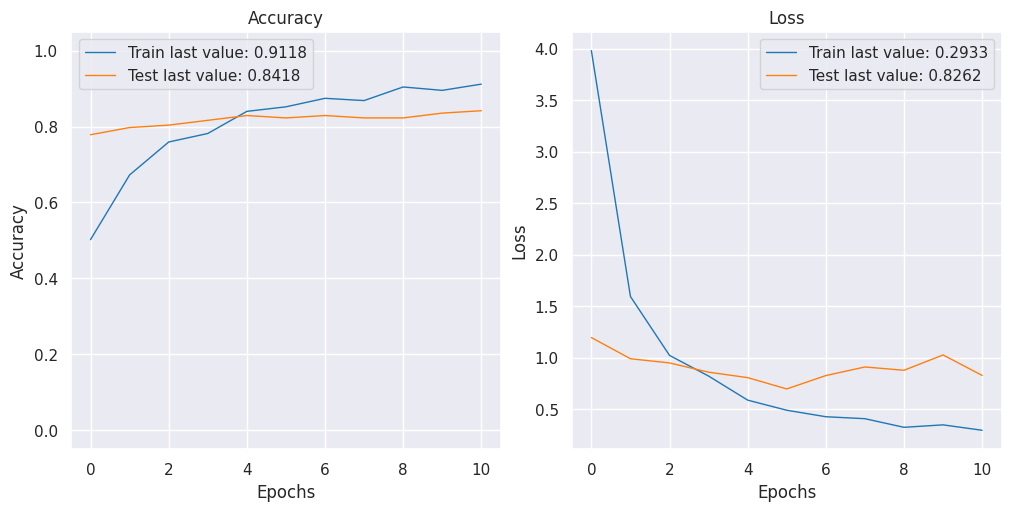

In [28]:
# Plot the history of training
show_history(history2)
plot_history(history2, path="model2_history.png")
plt.close()

## Troisième approche

Cette fois-ci, nous opterons pour une approche par dataset, sans data augmentation

Cette approche travaillant sur les données depuis le disque dur, nous allons devoir scinder notre jeu de données en jeu d'entrainement/validation et test directement sur les fichiers.

In [29]:
# Split into work data and validation data
data, data_test = train_test_split(df, test_size=0.15, random_state=8)

In [30]:
data

,image,category,label
413,./data/images/d36e6f157d1155369f763a0a434fb129...,Computers,2
971,./data/images/0906fd9cc604fbba05a502e01d763cd9...,Baby Care,0
210,./data/images/3113367c72125a3355af42426fe14f17...,Home Decor & Festive Needs,3
765,./data/images/3d8222014ec36292c1c143c5f5e12c29...,Kitchen & Dining,5
498,./data/images/11502f02601ff063bf7db0a618354652...,Watches,6
...,...,...,...
136,./data/images/73f460cd6f3fd206902d7097a1816405...,Kitchen & Dining,5
986,./data/images/c3c23b5aa5e388e5f71883f61d1a0561...,Home Decor & Festive Needs,3
133,./data/images/5531b9f454e2d75cfe00c3f795e06de5...,Kitchen & Dining,5
361,./data/images/dd0b73d97cea6cc71d263a77fa7982be...,Beauty and Personal Care,1


In [31]:
# Create path to store train and test datas
path_train = "./data/images_train/"
path_test = "./data/images_test/"

# After checking if directory exists or not, create them
if not os.path.exists(path_train):
    os.makedirs(path_train)
    # Copy files of the train set
    for idx, ser in data.iterrows():
        # Check if the category directory exists
        if not os.path.exists(path_train + ser["category"]):
            os.makedirs(path_train + ser["category"])
        # Get the name of the file
        image_name = ser["image"].split("/")[-1]
        shutil.copy(ser["image"], path_train+ser["category"]+"/"+image_name)
if not os.path.exists(path_test):
    os.makedirs(path_test)
    # Copy files of the test set
    for idx, ser in data_test.iterrows():
        # Check if the category directory exists
        if not os.path.exists(path_test + ser["category"]):
            os.makedirs(path_test + ser["category"])
        # Get the name of the file
        image_name = ser["image"].split("/")[-1]
        shutil.copy(ser["image"], path_test+ser["category"]+"/"+image_name)

### Préparation des images

In [32]:
# Create the 3 datasets
dataset_train = image_dataset_from_directory(
    path_train, labels="inferred", label_mode="categorical",
    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True,
    seed=8, validation_split=0.25, subset="training",
)
dataset_validation = image_dataset_from_directory(
    path_train, labels="inferred", label_mode="categorical",
    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True,
    seed=8, validation_split=0.25, subset="validation",
)
dataset_test = image_dataset_from_directory(
    path_test, labels="inferred", label_mode="categorical",
    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True,
    seed=8, validation_split=0, subset=None,
)

Found 892 files belonging to 7 classes.
Using 669 files for training.
Found 892 files belonging to 7 classes.
Using 223 files for validation.
Found 158 files belonging to 7 classes.


### Définition du modèle

In [33]:
# Create the model
with tf.device("/gpu:0"):
    model3 = create_model()

# Create the path where to save the trained model
model3_save_path = "./model3_best_weights.keras"
# Create the path where to save the logs of the training
model3_log_path = "./model3_training_log"
# Create checkpoints to save the model
checkpoint = ModelCheckpoint(model3_save_path, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode="min",)
# Create EarlyStopping to stop the training if the model find convergence before the end of the training
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# Create the list of callbacks
callbacks_list = [checkpoint, early_stopping]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Entrainement du modèle

In [35]:
# Check if the model have already been trained (and saved)
# If true, load the model from the save made
# Used mainly to save time replaying the notebook
if os.path.exists(model3_save_path):
    # Open the model from the file
    model3 = load_model(model3_save_path)
    # Open the log file of training
    history3 = np.load(model3_log_path + ".npy", allow_pickle="True").item()
else:
    # Training of the model on the train set
    with tf.device("/gpu:0"):
        history3 = model3.fit(dataset_train, epochs=50, batch_size=64,
                             callbacks=callbacks_list, validation_data=dataset_validation,
                             verbose=1)
        # Save the history of training to a file
        np.save(model3_log_path, history3.history)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.6730 - loss: 2.1949
Epoch 1: val_loss improved from inf to 1.34179, saving model to ./model3_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6718 - loss: 2.1965 - val_accuracy: 0.7444 - val_loss: 1.3418
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7545 - loss: 1.4092
Epoch 2: val_loss did not improve from 1.34179
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.7537 - loss: 1.4058 - val_accuracy: 0.7444 - val_loss: 1.3825
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7822 - loss: 0.9425
Epoch 3: val_loss improved from 1.34179 to 1.13581, saving model to ./model3_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.7828 - loss: 0.9412 - val_accuracy: 0.7892 - val_loss: 1.1358
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8105 - loss: 0.7066
Epoch 4: val_loss improved from 1.13581 to 1.11809, saving model to ./model3_best_wei

### Scoring et analyse

In [36]:
# Get the scores 
loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_validation, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9969 - loss: 0.0069
Training Accuracy: 0.9985

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7979 - loss: 0.9441
Validation Accuracy:  0.8161


In [37]:
# Get the scores of the optimal epoch
model1.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_validation, verbose=False)
print("Validation Accuracy       :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy :  {:.4f}".format(accuracy))

Validation Accuracy       :  0.8161
Test Accuracy :  0.8354


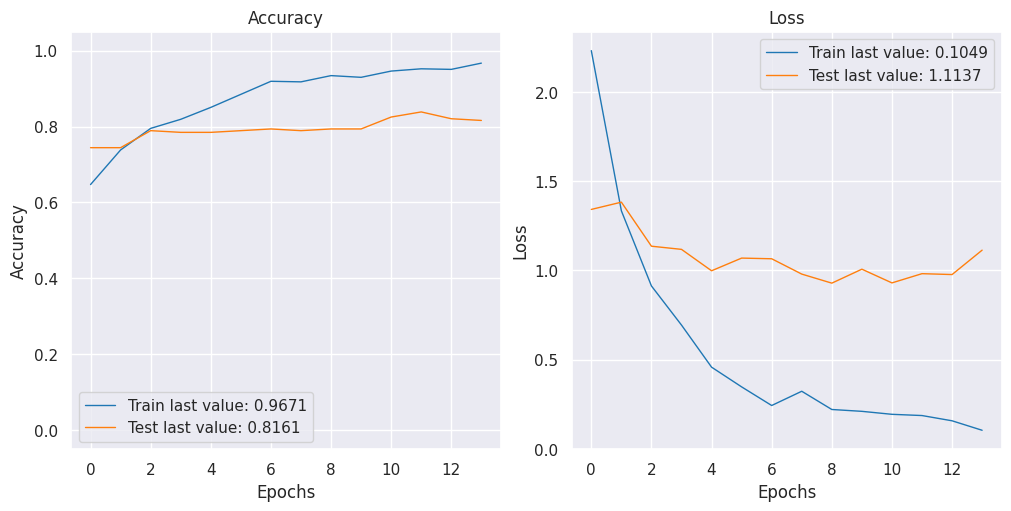

In [38]:
# Plot the history of training
show_history(history3)
plot_history(history3, path="model3_history.png")
plt.close()

## Quatrième approche

Cette fois, nous allons reprendre l'approche précédente en ajoutant de la data augmentation intégrée au modèle.

### Préparation des images

La préparation des images est effectuée comme précédemment, aussi, nous réutiliserons les variables suivantes :
* dataset_train
* dataset_validation
* dataset_test

### Définition du modèle

Pour la définition du modèle nous ne réutiliserons pas la fonction définie initialement, car ce modèle sera doté en premier lieu de la partie data augmentation

In [42]:
# Create the model
with tf.device("/gpu:0"):
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ])
    
    # Implement the pretrained model
    model4 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    
    # Set layers to non trainable to keep the weights of the pretrained model
    for layer in model4.layers:
        layer.trainable = False
    
    # Define the new model
    model4 = Sequential([
        data_augmentation,
        Rescaling(1./127.5, offset=-1),
        model4,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(7, activation="softmax"),
    ])

    # Compile the new model
    model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(model4.summary())

# Create the path where to save the trained model
model4_save_path = "./model4_best_weights.keras"
# Create the path where to save the logs of the training
model4_log_path = "./model4_training_log"
# Create checkpoints to save the model
checkpoint = ModelCheckpoint(model4_save_path, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode="min",)
# Create EarlyStopping to stop the training if the model find convergence before the end of the training
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# Create the list of callbacks
callbacks_list = [checkpoint, early_stopping]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Entrainement du modèle

In [43]:
# Check if the model have already been trained (and saved)
# If true, load the model from the save made
# Used mainly to save time replaying the notebook
if os.path.exists(model4_save_path):
    # Open the model from the file
    model4 = load_model(model4_save_path)
    # Open the log file of training
    history4 = np.load(model4_log_path + ".npy", allow_pickle="True").item()
else:
    # Training of the model on the train set
    with tf.device("/gpu:0"):
        history4 = model4.fit(dataset_train, epochs=50, batch_size=64,
                             callbacks=callbacks_list, validation_data=dataset_validation,
                             verbose=1)
        # Save the history of training to a file
        np.save(model4_log_path, history3.history)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.2148 - loss: 1.9965
Epoch 1: val_loss improved from inf to 1.49564, saving model to ./model4_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2176 - loss: 1.9914 - val_accuracy: 0.5561 - val_loss: 1.4956
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4975 - loss: 1.5240
Epoch 2: val_loss improved from 1.49564 to 1.17369, saving model to ./model4_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.4990 - loss: 1.5200 - val_accuracy: 0.6951 - val_loss: 1.1737
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6153 - loss: 1.2268
Epoch 3: val_loss improved from 1.17369 to 0.99086, saving model to ./model4_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6163 - loss: 1.2243 - val_accuracy: 0.7309 - val_loss: 0.9909
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6580 - loss: 1.0749
Epoch 4: val_loss improved from 0.99

### Scoring et analyse

In [44]:
# Get the scores 
loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_validation, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8886 - loss: 0.2945
Training Accuracy: 0.9013

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8266 - loss: 0.5077
Validation Accuracy:  0.7982


In [46]:
# Get the scores of the optimal epoch
model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_validation, verbose=False)
print("Validation Accuracy       :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy :  {:.4f}".format(accuracy))

Validation Accuracy       :  0.8296
Test Accuracy :  0.7848


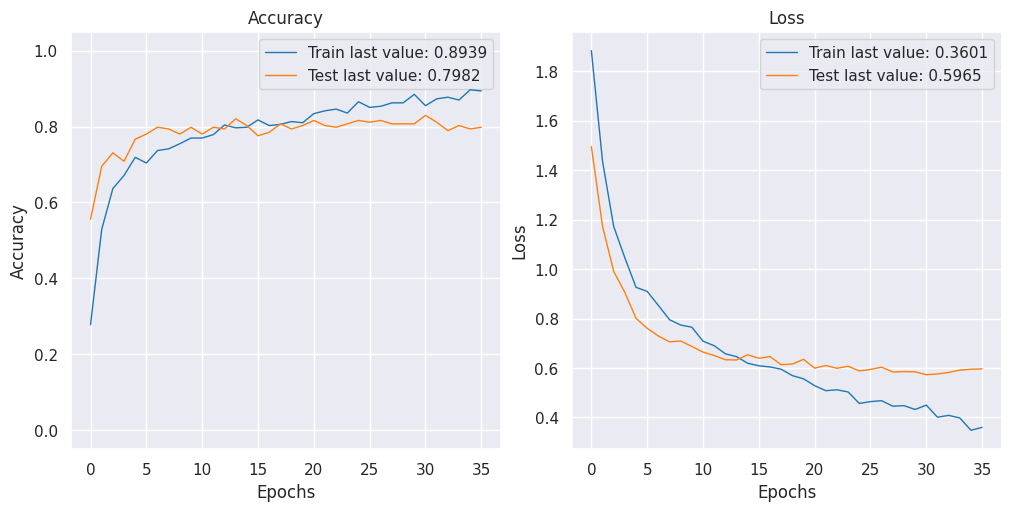

In [47]:
# Plot the history of training
show_history(history4)
plot_history(history4, path="model4_history.png")
plt.close()